# Combining eco-evolutionary theory and machine learning to improve our understanding of living systems


In this post, I explore the benefits and drawbacks of using empirical (ML)-based models versus mechanistic models for predicting ecosystem responses to perturbations. To evaluate these different modelling approaches, I use a mechanistic ecosystem model to generate a synthetic time series dataset.

By applying both modelling approaches to this dataset, I can evaluate their performance. While the ML-based approach yields accurate forecasts under unperturbed dynamics, it inevitably fails when it comes to predicting ecosystem response to perturbations. On the other hand, the mechanistic model, which is simplified version of the ground truth model to reflect a realistic scenario, is inaccurate and cannot forecast, but provides a more adequate approach to predict ecosystem response to unobserved scenarios.

To improve the accuracy of mechanistic models, I introduce inverse modelling, and in particular an approach that I have developed called piecewise inference. This approach allows for more accurate mechanistic models and can improve our understanding of the ecosystem by performing model selection.

Finally, I discuss how hybrid models, which incorporate both ML-based and mechanistic components, offer the potential to benefit from the strengths of both modelling approaches. By examining the strengths and limitations of these different modelling approaches, I hope to provide insights into how best to use them to advance our knowledge of ecological and evolutionary dynamics.

### Notes
- This post is under construction, and contain typos! If you find some, please contact me so that I can correct 
- For the sake of clarity, some pieces of code have voluntarily been hidden in external Julia files, which are loaded throughout the post. If you want to inspect them, check out those files in [the corresponding GitHub repository](https://github.com/vboussange/MyTutorials)

## Generating a synthetic dataset

To generate the synthetic dataset, I consider a 3 species ecosystem model, composed of a resource, consumer and prey species. The resource growth rate depends on water availability. Here is a simplified version of the dynamics

$$
\begin{align}
    \text{basal growth of } \text{🌱} &= f(\text{💧})\\
    \text{per capita growth rate }\text{🌱} &= \text{basal growth} - \text{competition} - \text{grazing} - \text{death}\\
    \text{per capita growth rate  }\text{🦓} &= \text{grazing} - \text{predation} - \text{death}\\
    \text{per capita growth rate  }\text{🦁} &= \text{predation} - \text{death}
\end{align}
$$

Let's implement that in Julia!

In [40]:
cd(@__DIR__)
import Pkg; Pkg.activate(".")
using PythonCall
nx = pyimport("networkx")
np = pyimport("numpy")
include("model.jl")
include("utils.jl");


  Activating project at `~/ETHZ/projects/MyTutorials/HybridModelling`


To implement the model, I use the library [`EcoEvoModelZoo`](https://github.com/vboussange/EcoEvoModelZoo.jl), which provides to the user ready-to-use mechanistic eco-evolutionary models. I use the model type `SimpleEcosystemModel`, cf. [documentation of EcoEvoModelZoo](https://vboussange.github.io/EcoEvoModelZoo.jl/dev/#EcoEvoModelZoo.SimpleEcosystemModel). Let's first construct the trophic network, and plot it

In [41]:
using EcoEvoModelZoo

N = 3 # number of species

pos = Dict(1 => [0, 0], 2 => [0.2, 1], 3 => [0, 2])
labs = Dict(1 => "Resource", 2 => "Consumer", 3 => "Prey")

foodweb = DiGraph(N)
add_edge!(foodweb, 2 => 1) # Consumer (node 2) feeds on Resource (node 1)
add_edge!(foodweb, 3 => 2) # Predator (node 3) fonds on consumer (node 2)
println(foodweb)



SimpleDiGraph{Int64}(2, [Int64[], [1], [2]], [[2], [3], Int64[]])


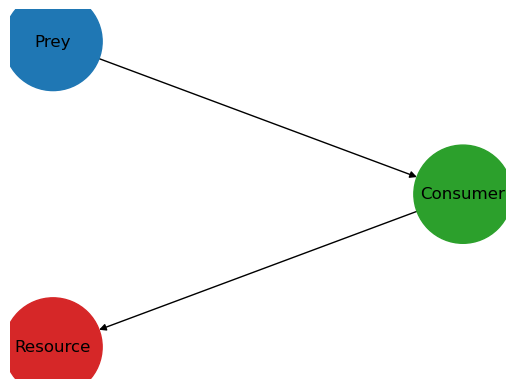

(<py Figure size 640x480 with 1 Axes>, <py Axes: >)

In [42]:
plot_foodweb(foodweb, pos, labs)

Then, I implement the processes that drive the dynamics of the ecoystem. Those include resource limitation for the resource species (e.g. limitation in nutrients), intraspecific competition for the resource species, reproduction, and feeding interactions (grazing and predation). To better understand this piece of code, you may want to refer to one of my previous blog post, ["Inverse ecosystem modelling made easy with PiecewiseInference.jl"](https://vboussange.github.io/post/piecewiseinference/).

In [43]:
function carrying_capacity(p, t)
    @unpack K₁₁ = p
    K = vcat(K₁₁, ones(Float32, N - 1))
    return K
end

carrying_capacity (generic function with 1 method)

In [44]:
function competition(u, p, t)
    @unpack A₁₁ = p
    A = spdiagm(vcat(A₁₁, zeros(Float32, 2)))
    return A * u
end

competition (generic function with 1 method)

In [45]:
resource_conversion_efficiency(p, t) = ones(Float32, N)

resource_conversion_efficiency (generic function with 1 method)

#### Functional responses

The feeding processes implemented are based on a functional response of type II. The attack rates `q` define the slope of the functional response, while the handling times `H` define the saturation of this response.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/FunctionalResponsesGraph.svg/1024px-FunctionalResponsesGraph.svg.png" width="500"/>



In [46]:
W = adjacency_matrix(foodweb)
I, J, _ = findnz(W)

function feeding(u, p, t)
    @unpack H₂₁, H₃₂, q₂₁, q₃₂ = p

    # handling time
    H = sparse(I, J, vcat(H₂₁, H₃₂), N, N)

    # attack rates
    q = sparse(I, J, vcat(q₂₁, q₃₂), N, N)

    return q .* W ./ (one(eltype(u)) .+ q .* H .* (W * u))
end

feeding (generic function with 1 method)

#### Dependence of resource growth rate on water availability

We model a time-varying water availability, and a growth rate of the resource which depends on the water availability.

In [47]:
water_availability(t) = sin.(2 * pi / 600 * 5 * t)

growth_rate_resource(r, water) = r * exp(-0.5*(water)^2)

intinsic_growth_rate(p, t) = [growth_rate_resource(p.r[1], water_availability(t)); p.r[2:end]]


intinsic_growth_rate (generic function with 1 method)

Let's plot what does the water availability looks like through time

In [48]:
ts = tspan[1]:1:tspan[end]
fig = figure()
plot(ts, water_availability.(ts))
xlabel("Time (days)")
ylabel("Water availability (normalized)")
fig.set_facecolor("None")


Python None

Now we define the numerical values for the parameter of the ecosystem model.

In [49]:
p_true = ComponentArray(H₂₁=Float32[1.24], # handling times
                        H₃₂=Float32[2.5],
                        q₂₁=Float32[4.98], # attack rates
                        q₃₂=Float32[0.8],
                        r=Float32[1.0, -0.4, -0.08], # growth rates
                        K₁₁=Float32[1.0], # carrying capacity for the resource
                        A₁₁=Float32[1.0]) # competition for the resource


ComponentVector{Float32}(H₂₁ = Float32[1.24], H₃₂ = Float32[2.5], q₂₁ = Float32[4.98], q₃₂ = Float32[0.8], r = Float32[1.0, -0.4, -0.08], K₁₁ = Float32[1.0], A₁₁ = Float32[1.0])

And with that, we can plot how we implemented the dependence between the resource growth rate and the water availability. It is a gaussian dependence, where the resource growth rate is maximum at a certain value of water availability. The intuition is that too much or too little water is detrimental to the resource.

In [50]:
water_avail_range = reshape(sort!(water_availability.(tsteps)),length(tsteps))

fig = figure()
plot(water_avail_range, growth_rate_resource.(p_true.r[1], water_avail_range))
xlabel("Water availability (normalized)")
ylabel("Resource basal growth rate")
fig.set_facecolor("none")

Python None

Now let's simulate the dynamics

In [51]:
u0_true = Float32[0.77, 0.060, 0.945]

mp = ModelParams(;p=p_true,
                tspan,
                u0=u0_true,
                solve_params...)

model = SimpleEcosystemModel(; 
                            mp, 
                            intinsic_growth_rate,
                            carrying_capacity,
                            competition,
                            resource_conversion_efficiency,
                            feeding)

`Model` SimpleEcosystemModel


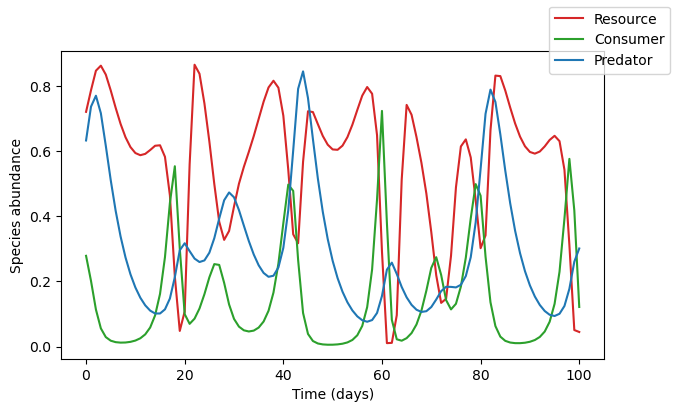

In [52]:
fig, ax = plot_time_series(simulate(model));

And let's generate a dataset by contaminating the model output with lognormally distributed noise.

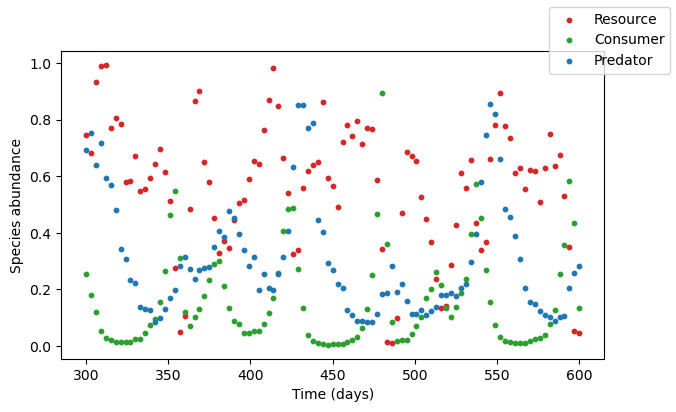

In [53]:
data = simulate(model) |> Array

# contaminating raw data with noise
data = data .* exp.(1f-1*randn(Float32, size(data)))

# plotting
fig, ax = subplots(figsize=(7,4))

for i in 1:size(data,1)
    ax.scatter(tsteps, data[i, :], label=labels_sp[i], color = species_colors[i], s=10.)
end
# ax.set_yscale("log")
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
fig.legend()
display(fig)


## Empirical modelling

Let's build a ML-model, and train the model on the time series.

We'll use a recurrent neural network model

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/1280px-Recurrent_neural_network_unfold.svg.png)


More specifically, we use a Long Short Term Memory cell, connected to two dense layers with `relu` and a radial basis  (`rbf`) activation functions.

In [54]:
using Flux # Julia deep learning library

include("rnn.jl") # Load some utility functions
args = ArgsEco() # Set up hyperparameters

rbf(x) = exp.(-(x.^2)) # custom activation function

hls = 64 # hidden layer size

# Definition of the RNN
# our model takes in the ecosystem state variables, together with current water availability
rnn_model = Flux.Chain(LSTM(N + 1, hls),
            Flux.Dense(hls, hls, relu),
                Flux.Dense(hls, N, rbf))

@time train_model!(rnn_model, data, args)   # Train and output model

┌ Info: Epoch 100 / 1000, train loss: 470.464
└ @ Main /Users/victorboussange/ETHZ/projects/MyTutorials/HybridModelling/rnn.jl:76
┌ Info: Epoch 200 / 1000, train loss: 254.314
└ @ Main /Users/victorboussange/ETHZ/projects/MyTutorials/HybridModelling/rnn.jl:76


┌ Info: Epoch 300 / 1000, train loss: 174.331
└ @ Main /Users/victorboussange/ETHZ/projects/MyTutorials/HybridModelling/rnn.jl:76
┌ Info: Epoch 400 / 1000, train loss: 143.136
└ @ Main /Users/victorboussange/ETHZ/projects/MyTutorials/HybridModelling/rnn.jl:76


┌ Info: Epoch 500 / 1000, train loss: 127.131
└ @ Main /Users/victorboussange/ETHZ/projects/MyTutorials/HybridModelling/rnn.jl:76
┌ Info: Epoch 600 / 1000, train loss: 106.003
└ @ Main /Users/victorboussange/ETHZ/projects/MyTutorials/HybridModelling/rnn.jl:76


┌ Info: Epoch 700 / 1000, train loss: 104.953
└ @ Main /Users/victorboussange/ETHZ/projects/MyTutorials/HybridModelling/rnn.jl:76
┌ Info: Epoch 800 / 1000, train loss: 130.294
└ @ Main /Users/victorboussange/ETHZ/projects/MyTutorials/HybridModelling/rnn.jl:76


┌ Info: Epoch 900 / 1000, train loss: 82.938
└ @ Main /Users/victorboussange/ETHZ/projects/MyTutorials/HybridModelling/rnn.jl:76
┌ Info: Epoch 1000 / 1000, train loss: 83.527
└ @ Main /Users/victorboussange/ETHZ/projects/MyTutorials/HybridModelling/rnn.jl:76


 25.948131 seconds (28.75 M allocations: 43.056 GiB, 11.91% gc time, 3.40% compilation time: 4% of which was recompilation)


We can now simulate our trained model in an autoregressive manner, which allows us to forecast over time steps beyond the training dataset.

In [55]:
tsteps_forecast = tspan[end]+dt:dt:tspan[end]+100*dt

water_availability_range = water_availability.(vcat(tsteps, tsteps_forecast))
init_states = data[:,1:2]

pred_rnn = simulate(rnn_model, init_states, water_availability_range)


3×200 Matrix{Float32}:
 0.770124   0.868583   0.890367   0.832631   …  0.446571  0.300328  0.243466
 0.0946546  0.0630704  0.0414449  0.0266201     0.543786  0.552753  0.329526
 0.560791   0.567691   0.533428   0.457799      0.320169  0.473812  0.717304

And let's plot it. Plain lines are the model output for the training time span, and dashed lines are the model forecast.

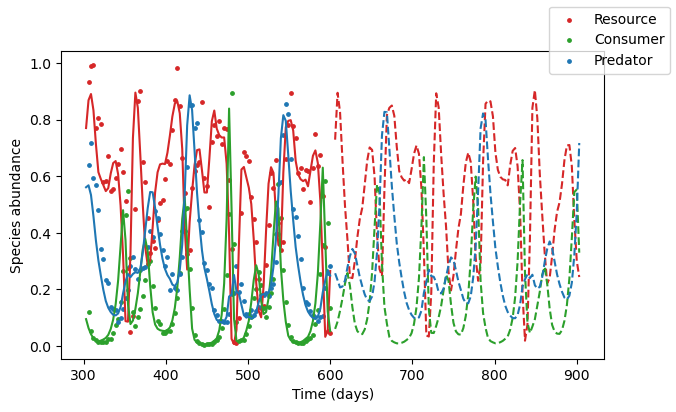

In [56]:


fig, ax = subplots(1, figsize=(7,4))
for i in 1:N
    ax.scatter(tsteps[3:end], 
                data[i, 3:end], 
                label = labels_sp[i], 
                color = species_colors[i],
                s = 6.)
    ax.plot(tsteps[2:end], 
            pred_rnn[i,1:length(tsteps)-1], 
            c = species_colors[i])
    ax.plot(tsteps_forecast .+ dt, 
            pred_rnn[i,length(tsteps):end], 
            linestyle="--", 
            c = species_colors[i])
end
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
fig.legend()
display(fig)

Looks pretty good!

Now let's see what happens if the resource species go extinct. Because this species is at the bottom of the trophic chain, we expect a collapse of the ecosystem.

In [57]:
water_availability_range = water_availability.(tsteps)
init_states = data[:,1:2]
init_states[1,:] .= 0.
pred_rnn = simulate(rnn_model, init_states, water_availability_range)

3×100 Matrix{Float32}:
 0.722818   0.860248   0.917568   …  0.0228393  0.0747056  0.35526
 0.0794953  0.0436559  0.0269104     0.287009   0.094745   0.0495397
 0.572823   0.545313   0.498066      0.235217   0.256965   0.242728

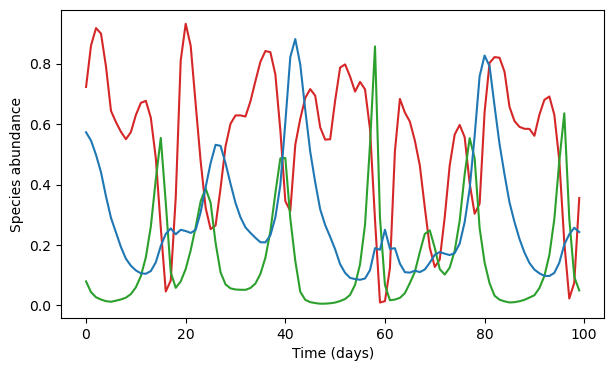

In [58]:
fig, ax = subplots(1, figsize=(7,4))
for i in 1:N
    ax.plot( 
            pred_rnn[i,:], 
            c = species_colors[i])
end
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
display(fig)

There is clearly a problem! The RNN model outputs almost unchanged dynamics, predicting that magically, the resource would revive. This were to be expected: the ML model did not see this type of collapse dynamics, so it cannot invent it.

In summary, ML-based model

- 👍 Very good for interpolation
- 👍 Does not require any knowledge from the system, only data!
- 👎 Cannot extrapolate to unobserved scenarios

## Mechanistic modelling

We now define a new mechanistic model, deliberatively falsifying the numerical value of the parameters compared to the baseline ecosystem model, and simplifying the resource dependence on water availbility by assuming that its growth rate is constant. The resulting `model_mechanistic` is as such an inaccurate representation of the baseline ecosystem model.

In [59]:
p_mech = ComponentArray(H₂₁=Float32[1.1],
                        H₃₂=Float32[2.3],
                        q₂₁=Float32[4.98],
                        q₃₂=Float32[0.8],
                        r = Float32[1.0, -0.4, -0.08],
                        K₁₁=Float32[0.8],
                        A₁₁=Float32[1.2])

u0_mech = Float32[0.77, 0.060, 0.945]

mp = ModelParams(; p=p_mech,
                u0=u0_mech,
                solve_params...)

growth_rate_mech(p, t) = p.r

model_mechanistic = SimpleEcosystemModel(; mp, intinsic_growth_rate = growth_rate_mech ,
                                        carrying_capacity,
                                        competition,
                                        resource_conversion_efficiency,
                                        feeding)

simul_data = simulate(model_mechanistic)


retcode: Success
Interpolation: 1st order linear
t: 101-element Vector{Float64}:
 300.0
 303.0
 306.0
 309.0
 312.0
 315.0
 318.0
 321.0
 324.0
 327.0
   ⋮
 576.0
 579.0
 582.0
 585.0
 588.0
 591.0
 594.0
 597.0
 600.0
u: 101-element Vector{Vector{Float32}}:
 [0.35681617, 0.25076807, 0.53078616]
 [0.43750805, 0.18164492, 0.6046971]
 [0.5302157, 0.12319935, 0.6313447]
 [0.58675706, 0.08220317, 0.609244]
 [0.61556184, 0.05791681, 0.5548506]
 [0.6293472, 0.045777805, 0.48815525]
 [0.6348813, 0.041632067, 0.42266676]
 [0.63514787, 0.043459423, 0.36515173]
 [0.6308819, 0.05119311, 0.31852293]
 [0.621225, 0.06643981, 0.28416827]
 ⋮
 [0.35969865, 0.29956064, 0.4289447]
 [0.3546816, 0.25409386, 0.5262004]
 [0.43244424, 0.18495828, 0.60201573]
 [0.5263857, 0.12572324, 0.63124937]
 [0.58472395, 0.08382597, 0.6112925]
 [0.61455756, 0.058799665, 0.5580067]
 [0.6288918, 0.046168245, 0.49153915]
 [0.6347438, 0.041689146, 0.4257851]
 [0.6352414, 0.043234285, 0.3677817]

Let's now plot its dynamics

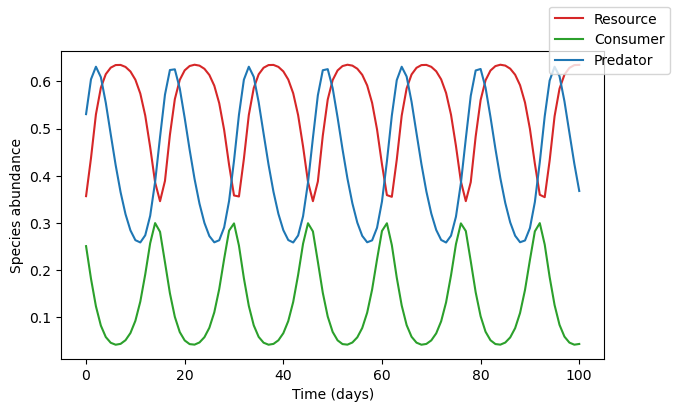

In [60]:
plot_time_series(simul_data);

The dynamics looks quite different from the time series, and cannot provide any realistic forecast of the ecosystem state in the future. Yet, it does capture some of the dynamics, since it reproduces an oscillatory behavior. As such, we can assume that this ecosystem model captures some of the processes driving the baseline ecosystem dynamics.

We can now use this mechanistic model to again try to understand what happens if the resource species go extinct. 

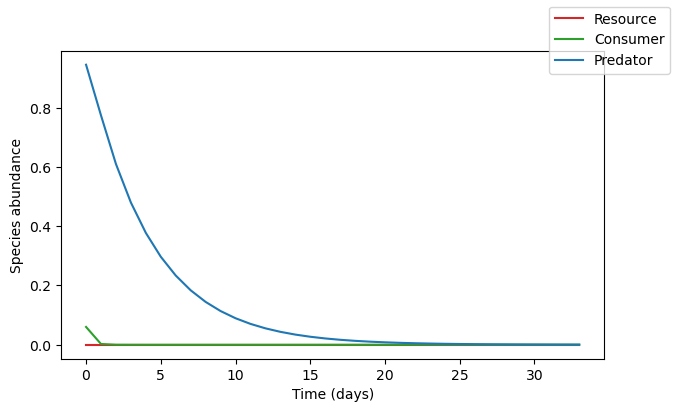

In [61]:
simul_data = simulate(model_mechanistic, 
                u0 = Float32[0., 0.060, 0.945], 
                saveat=0:dt:100.)

plot_time_series(simul_data);

That makes much more sense!!! The model does predict a collapse, and we can even estimate how long it will take for the system to fully collapse.

In summary, mechanistic models

- 👍 Very good for extrapolating to novel scenarios
- 👎 Hard to parametrise
- 👎 Inacurate

Now let's see how we can improve this ecosystem model, by making better use of the dataset that we have at hand. 

## Inverse modelling

**Use the observed data to infer the parameters of a model**

There are two broad classes of methods to perform inverse modelling:

- **Bayesian inference**
  - provide **uncertainties estimations**
  - does not scale well with the number of parameters to explore

- **Variational optimization**
  - Does not suffer from the curse of dimensionality
  - Convergence to local minima 
  - Need for parameter sensitivity

To better understand the caveats of the variational optimization approach, let's further explain it. This method consists in defining a certain loss function, which allows to measure a distance between the model output and the observations:

$$
\text{L} = \sum_i [\text{observations} - \text{simulations}]^2
$$

Variational optimization methods seek to minimize $L$ by using its gradient (sensitivity) with respect to the model parameters. This gradient indicates how to update the parameters to reduce the distance between the observations and the simulation outputs. 

This can be done iteratively until finding the parameters that minimize the loss, as illustrated below.



![](https://upload.wikimedia.org/wikipedia/commons/a/a3/Gradient_descent.gif?20190425084312)

This works very well! In theory.

In practice, the landscape is rugged, as in the picture below

![](img/2d_landscape_rugged.png)

By following the gradient in such a landscape, variational optimization methods tend to get stuck in wrong regions of the parameter space, and provide false estimate.

### PiecewiseInference.jl

[PiecewiseInference.jl](https://github.com/vboussange/PiecewiseInference.jl) is a julia package that I have authored, which implements a method to smoothen the loss landscape, and that permits to automatically obtain the model parameter sensitivity. It is detailed in the following preprint

> ~~Boussange, V., Vilimelis-Aceituno, P., Pellissier, L., Mini-batching ecological data to improve ecosystem models with machine learning. [bioRxiv](https://www.biorxiv.org/content/10.1101/2022.07.25.501365v1) (2022), 46 pages.~~

⚠️ We will shortly rename this preprint in a revised version, as the term "mini batching" is confusing. We now prefer the term "partitioning"



The method works by training the model on small chunks of data

![](img/loss2.png)

Let's use it to tune the paramters of our mechanitic model. We'll group data points in groups of 11, indicated by the argument `group_size = 11`

![](img/land_derugged.png)


In [62]:
using PiecewiseInference
include("utils.jl"); # some utility functions defining `inference_problem_args` and `piecewise_MLE_args`

loss_likelihood(data, pred, rg) = sum((log.(data) .- log.(pred)).^2)

infprob = InferenceProblem(model_mechanistic, 
                            p_mech; 
                            loss_likelihood, 
                            inference_problem_args...);

@time res_mech = piecewise_MLE(infprob;
                        group_size = 11,
                        data = data,
                        tsteps = tsteps,
                        optimizers = [Adam(1e-2)],
                        epochs = [500],
                        piecewise_MLE_args...)

piecewise_MLE with 101 points and 10 groups.


┌ Info: Training started
└ @ PiecewiseInference /Users/victorboussange/ETHZ/projects/PiecewiseInference.jl/src/piecewise_MLE.jl:270
┌ Info: Running optimizer Adam
└ @ PiecewiseInference /Users/victorboussange/ETHZ/projects/PiecewiseInference.jl/src/piecewise_MLE.jl:441


Current loss after 50 iterations: 18.4744815826416


Current loss after 100 iterations: 13.287967681884766


Current loss after 150 iterations: 12.31714916229248


Current loss after 200 iterations: 11.989354133605957


Current loss after 250 iterations: 11.853116989135742


Current loss after 300 iterations: 11.786518096923828


Current loss after 350 iterations: 11.750250816345215


Current loss after 400 iterations: 11.728414535522461


Current loss after 450 iterations: 11.714520454406738


Current loss after 500 iterations: 11.705473899841309


132.387890 seconds (1.01 G allocations: 170.439 GiB, 13.03% gc time, 2.13% compilation time: 97% of which was recompilation)


┌ Info: Minimum loss for all batches: 11.705473899841309
└ @ PiecewiseInference /Users/victorboussange/ETHZ/projects/PiecewiseInference.jl/src/piecewise_MLE.jl:287


`InferenceResult` with model SimpleEcosystemModel


Now let's plot what does this trained model predicts

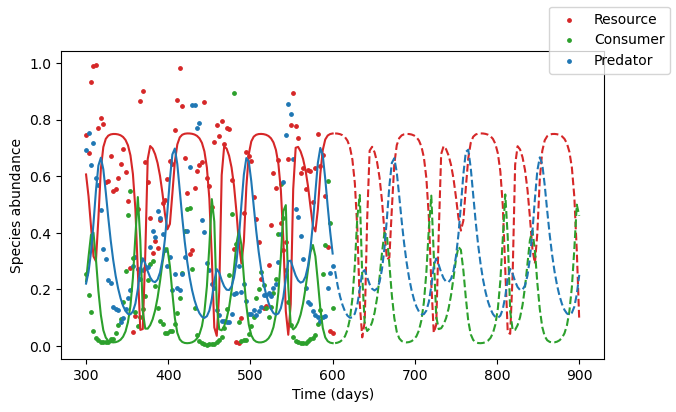

In [63]:
simul_mech_forecast = simulate(model_mechanistic, 
                                p = res_mech.p_trained, 
                                u0 = data[:,1],
                                saveat = vcat(tsteps, tsteps_forecast), 
                                tspan = (0, tsteps_forecast[end]));

fig, ax = subplots(1, figsize=(7,4))
for i in 1:N
    ax.scatter(tsteps, 
                data[i,:], 
                label = labels_sp[i], 
                color = species_colors[i],
                s = 6.)
    ax.plot(tsteps[1:end], 
            simul_mech_forecast[i,1:length(tsteps)], 
            c = species_colors[i])
    ax.plot(tsteps_forecast, 
            simul_mech_forecast[i,length(tsteps)+1:end], 
            linestyle="--", 
            c = species_colors[i])
end
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
fig.legend()
display(fig)

Looks much better! The model now captures doubling period oscillations.

In summary, mechanistic models

- 👍 Very good for extrapolating to novel scenarios
- 👎 ~~Hard to parametrise~~
- 👎 Inacurate

### Model selection

To improve the accuracy, one can try to formulate different models corresponding to alternative hypotheses about the processes driving the ecosystem dynamics. For instance, we could compare the performance of this model to an alternative model, which would capture some sort of dependence between the water availability and the resource growth rate. 

If we find that the refined model performs better than the model with constant growth rate, we have learnt that water availability is an important driver that affects the ecosystem dynamics.

## Hybrid models

Assume that we have no idea on what the dependence of the resource growth rate on water availability may look like. 

To proceed, we can define a very generic parametric function that can capture any sort of dependence, and then try to learn the parameters of this function from the data.

Neural networks are parametric functions that are highly suited for this sort of task. So we'll build a hyrbid model, which contains the mechanistic components of the previous model, but where the resource growth rate is parametrized by a neural network.

### 🤖 + 🔬= 🤯

Below, we define the neural network, and the resource growth rate based on this neural net.


In [64]:
using Lux
rng = Random.default_rng()
# Multilayer FeedForward
hlsize = 5
neural_net = Lux.Chain(Lux.Dense(1,hlsize,rbf), 
                        Lux.Dense(hlsize,hlsize, rbf), 
                        Lux.Dense(hlsize,hlsize, rbf), 
                        Lux.Dense(hlsize, 1))
# Get the initial parameters and state variables of the model
p_nn, st = Lux.setup(rng, neural_net)
p_nn = p_nn |> ComponentArray

growth_rate_resource_nn(p_nn, water) = neural_net([water], p_nn, st)[1]

function hybrid_growth_rate(p, t)
    return [growth_rate_resource_nn(p.p_nn, water_availability(t)); p.r]
end



hybrid_growth_rate (generic function with 1 method)

Now we define our new hybrid model that implements this `hybrid_growth_rate` function

In [65]:
p_hybr = ComponentArray(H₂₁=p_mech.H₂₁,
                        H₃₂=p_mech.H₃₂,
                        q₂₁=p_mech.q₂₁,
                        q₃₂=p_mech.q₃₂,
                        r = p_mech.r[2:3],
                        K₁₁=p_mech.K₁₁,
                        A₁₁=p_mech.A₁₁,
                        p_nn = p_nn)

mp = ModelParams(;p=p_hybr,
                u0=u0_mech,
                solve_params...)

model_hybrid = SimpleEcosystemModel(; mp, 
                                    intinsic_growth_rate = hybrid_growth_rate,
                                    carrying_capacity,
                                    competition,
                                    resource_conversion_efficiency,
                                    feeding)

`Model` SimpleEcosystemModel


And we train it

In [66]:
infprob = InferenceProblem(model_hybrid, 
                            p_hybr; 
                            loss_likelihood, 
                            inference_problem_args...);

res_hybr = piecewise_MLE(infprob;
                    group_size = 11,
                    data = data,
                    tsteps = tsteps,
                    optimizers = [Adam(2e-2)],
                    epochs = [500],
                    piecewise_MLE_args...)

The loss has signficiantly reduced. This means that this model better explains the dynamics, and as such, we have discovered that water avilability is indeed an important driver of ecosystem dynamics! Let's plot the simulation output of this hyrbid model

In [ ]:
simul_hybr_forecast = simulate(model_hybrid, 
                                p = res_hybr.p_trained, 
#                                 u0 = res_hybr.u0s_trained[1],
                                u0 = data[:,1],
                                saveat = vcat(tsteps, tsteps_forecast), 
                                tspan = (0, tsteps_forecast[end]));

In [ ]:
fig, ax = subplots(1, figsize=(7,4))
for i in 1:N
    ax.scatter(tsteps, 
                data[i,:], 
                label = labels_sp[i], 
                color = species_colors[i],
                s = 6.)
    ax.plot(tsteps[1:end], 
        simul_hybr_forecast[i,1:length(tsteps)], 
            c = species_colors[i])
    ax.plot(tsteps_forecast, 
            simul_hybr_forecast[i,length(tsteps)+1:end], 
            linestyle="--", 
            c = species_colors[i])
end
ax.set_ylabel("Species abundance")
ax.set_xlabel("Time (days)")
fig.set_facecolor("None")
ax.set_facecolor("None")
fig.legend()
display(fig)

The cool thing is that although it contains a fully parametric component (the neural network), this hybrid can still extrapolate, because it is constrained by mechanistic processes.

In [ ]:
plot_time_series(simulate(model_hybrid, 
                p = res_hybr.p_trained, 
                u0 = Float32[0., 0.060, 0.945], 
                saveat=0:dt:100.));

And what's even cooler is that by interpreting the neural network, we can actually learn a new process: the shape of the dependence between the resource growth rate and the water availability!


In [ ]:
water_avail = reshape(sort!(water_availability.(tsteps)),1,:)

p_nn_trained = res_hybr.p_trained.p_nn
gr = neural_net(water_avail, p_nn_trained, st)[1]


fig, ax = subplots(1)
ax.plot(water_avail[:], 
        gr[:], 
        label="Neural network",
        linestyle="--")

gr_true = model.mp.p[1] .* exp.(-0.5 .* water_avail.^2)
ax.plot(water_avail[:], gr_true[:], label="Ground truth")
ax.set_ylim(0,2)
ax.set_xlim(-2,2)
ax.legend()
xlabel("Water availability (normalized)")
ylabel("Resource basal growth rate")
display(fig)


## Wrap-up

Hybrid approaches are the future! But they

- Require 
  - domain **specific knowledge**
  - expertise in **mechanistic modelling**
    - 👍 [EcoEvoModelZoo.jl](https://github.com/vboussange/EcoEvoModelZoo.jl)
  - expertise in **machine learning**
    - 👍 [Flux.jl model zoo](https://github.com/FluxML/model-zoo)
- Requires **differentiable programming** and **interoperability** between scientific libraries
  - What <img src="https://docs.julialang.org/en/v1/assets/logo.svg" width="100"/>
 is best at

  - But JAX is also very cool 🫠
